# Multidimensional scaling for genetic population differences.

Using adataset of 42 human geographic populations collected by Cavalli-Sforza et al. in The History and
Geography of Human Gene. 

In [1]:
import warnings; warnings.simplefilter('ignore')

import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import numpy.linalg as la
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

data = np.load("mds-population.npz")
print(data['D']) # Distance matrix
print(data['population_list']) # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


### Using multidimensional scaling to coerce D into a 2-dimensional vector representation.

In [2]:
print("Original shape: ",data['D'].shape)
embedding = MDS(n_components=2)
data_transformed = embedding.fit_transform(data['D'])
print("Transformed shaped: ",data_transformed.shape)

Original shape:  (42, 42)
Transformed shaped:  (42, 2)


### MDS will output a set of points such that the Euclidean distance between every pair of points approximates the Nei’s distance between these populations:

Multidimensional scaling (MDS) is a tool that can be used to visualize the level of similarity of individual objects in a dataset. It can transform pairwise relationships among a set of objects into points on a multidimensional space. MDS attempts to maintain the between-object "distances" as the dimensions of the dataset are reduced. MDS assumes that "flattening" the data will not result in a meaningful loss of data. This could fail if a set's objects are arranged in multidimensional space in such a way that meaningful data must be lost with reduction in dimension. We could measure the amount of information lost by measuring the "stress" (sum of squared distance of the disparities and the distances for all constrained points). A higher stress means a higher distortion of the true data. It should be noted that the exact placement of items within a cluster has only a small effect on the overall stress and so may be quite arbitrary.
(analytictech.com/borgatti/mds.htm)

### Increasing the dimensionality of the MDS result will Increase the quality of the output by. 
Five dimensions are necessary to capture most of variation in data. We applied multidimensional scaling to the data and computed the stress (sum of squared distance of the disparities and the distances for all constrained points) associated with the number of dimensions. Stress is a good metric for capturing the variation in the data because it measures the change in distance between observations as dimensionality is reduced. Up until about the 5th dimension, the reduction in dimension does not lead significant information loss. However, reducing the data below five dimensions leads to meaningful loss. 
(analytictech.com/borgatti/mds.htm)

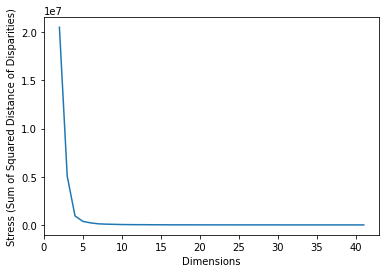

In [3]:
stress_array = []

for dimensions in range (2, 42):
    mds = MDS(n_components = dimensions)
    coordinates = mds.fit(data['D']).embedding_
    # stress = sum of squared distance of the disparities and the distances for all constrained points
    stress = mds.stress_
    stress_array.append(stress)
    
fig, ax = plt.subplots()
plt.plot(range(2,42),stress_array)
plt.xlabel("Dimensions")
plt.ylabel("Stress (Sum of Squared Distance of Disparities)")
plt.show()

### Using MDS to embed the distance matrix into only two dimensions and showing the resulting scatterplot:

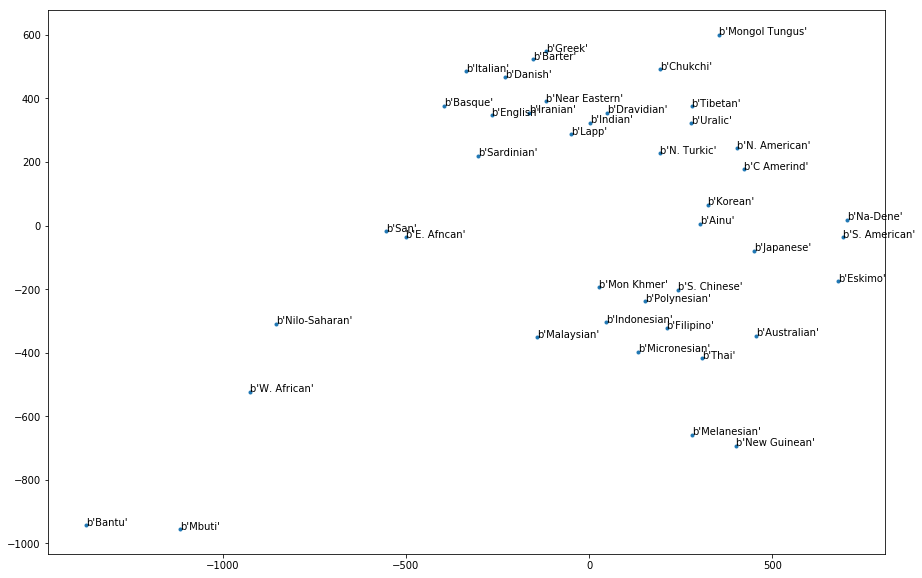

In [4]:
embedding = MDS(n_components=2)
transformed = embedding.fit_transform(data['D'])

fig, ax = plt.subplots(figsize=(15,10))
plt.plot(transformed[:,0],transformed[:,1],'.')
for index, label in enumerate (data['population_list']):
    ax.annotate(label, (transformed[:,0][index],transformed[:,1][index]))
plt.show()

### Running k-means on 2D embedding and showing the resulting clusters:

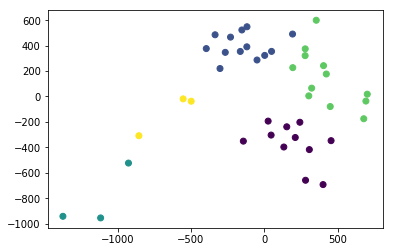

In [5]:
num_clusters = 5

kmeans = KMeans(n_clusters = num_clusters, random_state = 0)

labels = kmeans.fit_predict(transformed)
plt.scatter(transformed[:,0], transformed[:,1], c = labels)
plt.show()

### Using hierarchical clustering to cluster the original distance matrix:

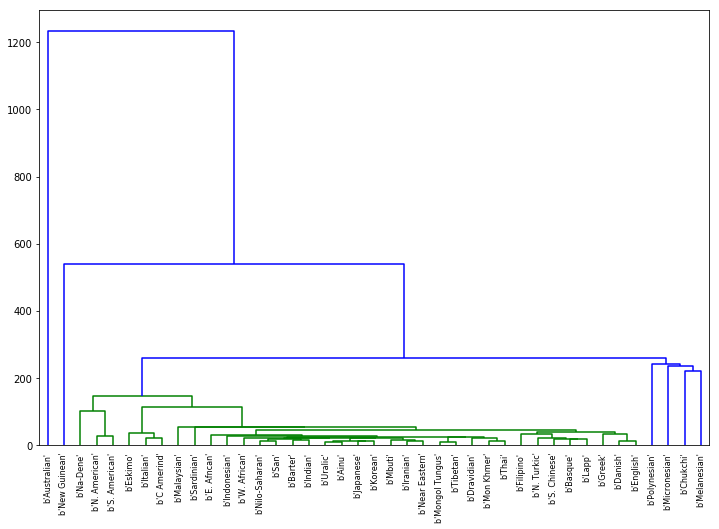

In [6]:
import scipy.cluster.hierarchy as hierarchy
labelList = [i for i in data['population_list']]

plt.figure(figsize = (12, 8)) 
z = hierarchy.linkage(data['D'], method = 'ward')
dend = hierarchy.dendrogram(hierarchy.linkage(z), color_threshold=180, labels = labelList)

### Transforming the resulting tree into a flat clustering of points: 

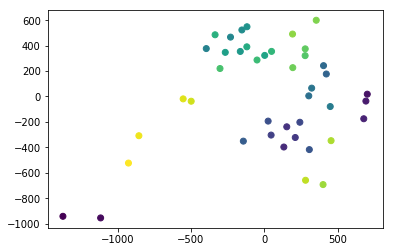

In [7]:
z = hierarchy.linkage(data['D'], method='single')
threshold = 5
clusters = hierarchy.fcluster(z, threshold, criterion='distance')
plt.scatter(transformed[:,0], transformed[:,1], c=clusters)

### Clustering with k-medoids:

In [8]:
# KMedoids implementation from: https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py

import numpy as np
import random

def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

# KMedoids implementation from: https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py

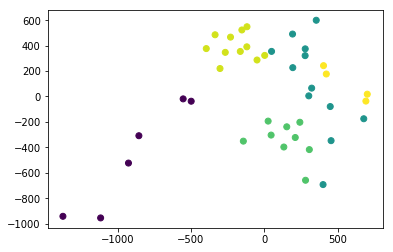

In [9]:
mediod_cluster_labels, curr_medoids = cluster(data['D'],5)
fig, ax = plt.subplots()
ax.scatter(transformed[:,0],transformed[:,1], c = mediod_cluster_labels)
plt.show()